# Manual Review of Promising Candidates

Here we list out a bunch of candidates and teir parameters which have promising weirdness in their ligghtcurves...
We'll add that to our talk... once the data is cumulated

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd
from scipy.optimize import curve_fit
#import aliensims as dy
from ellc import lc
import os
from transit import occultnonlin, occultquad
from interpolation import load_grids, lc_interpolate_v2

### List of candidates
<ol>
    <li>KIC 8110757: potential eclipsing binary but highly assymetric curve
    <li>KIC 5357901 (KOI 188b, Kepler-425): tidally fluctuating hot jupiter
    <li>KIC 5358624: tidally fluctuating hot jupiter
    <li>KIC 9941662: seemsto be contact binary signatures
    <li>KIC 6372268: contact binary signatures
    <li>KIC 9025971: seems to be some tiny mid transit flares... could just be noise
    <li>KIC 8308347: personal curiosity
    <li>KIC 10975146: assymetric like 1 ... confirmed planet
    <li>KIC 2557430: assymetric peaks
    <li>KIC 10295951: some peaky sigs ... still candidate
    <li>KIC 11404644: Probably false alarm
    <li>KIC 6620003: shows some improvement
    <li>KIC 8323764:
</ol>

[8840] CAN rank122_009944201_1.jpg
     [721] CAN rank131_008616873_1.jpg
[393] CAN rank237_001161345_1.jpg
        [216] CAN rank272_007380537_1.jpg
[956] CAN rank306_006620003_1.jpg
            [7855] CAN rank368_006842345_1.jpg
[582] CAN rank377_010295951_1.jpg
[7596] CAN rank384_011404644_1.jpg
        [3044] CAN rank386_010395543_1.jpg
[5676] CAN rank402_009574614_1.jpg
        [1531] CAN rank434_010158418_1.jpg
        [92] CAN rank446_003453214_1.jpg
            [3534] CAN rank488_006309763_1.jpg
     [37] CAN rank496_011138155_1.jpg
    [1204] CAN rank500_012120943_1.jpg
    [269] CAN rank508_009140402_1.jpg
    [2757] CAN rank517_008684730_1.jpg
      [3015] CAN rank518_009119458_1.jpg
[1646] CAN rank540_006300348_1.jpg
[2739] CAN rank552_007051180_1.jpg
     [3602] CAN rank582_002569995_1.jpg
      [172] CAN rank585_006526710_1.jpg
[5387] CAN rank586_008323764_1.jpg

In [3]:
#Directory setting for candidate list
#FILEPATH_FPS="E:\Masters_Project_Data\\alienworlds_fps\\"
FILEPATH_FPS="/media/ushasi/Elements/Masters_Project_Data/alienworlds_fps/"
k1 = 'kplr008110757-20160128150956_dvt.fits'
k2 = 'kplr005357901-20160128150956_dvt.fits'
k3 = 'kplr005358624-20160128150956_dvt.fits'
k4 = 'kplr009941662-20160128150956_dvt.fits'
k5 = 'kplr006372268-20160128150956_dvt.fits'
k6= 'kplr009025971-20160128150956_dvt.fits'
k7= 'kplr008308347-20160128150956_dvt.fits'
k8= 'kplr010975146-20160128150956_dvt.fits'
k9='kplr002557430-20160128150956_dvt.fits'
k10='kplr010295951-20160128150956_dvt.fits'
k11='kplr011404644-20160128150956_dvt.fits'
k12='kplr006620003-20160128150956_dvt.fits'
k13='kplr008323764-20160128150956_dvt.fits'

ks1='kplr001161345-20160128150956_dvt.fits'
ks2='kplr009944201-20160128150956_dvt.fits'
ks3='kplr009574614-20160128150956_dvt.fits'
ks4='kplr006300348-20160128150956_dvt.fits'
ks5='kplr007051180-20160128150956_dvt.fits'

kt1='kplr006681618-20160128150956_dvt.fits'
kt2='kplr008240109-20160128150956_dvt.fits'
kt3='kplr009597095-20160128150956_dvt.fits'

points, vals, phases = load_grids()



(10, 10, 7, 10, 3, 300) (10, 10, 300)


### Model fitting functions
Here are routines needed for fitting the models if and when...

In [4]:
#algol model:
def sort_data(hdu, hduno):
    flux = []
    flux_white=[]
    phase = []
    lc_err=[]
    model = []
    tp = hdu[hduno].header['TPERIOD']
    for ph, fl,wl, ml, err in zip(hdu[hduno].data['PHASE'],hdu[hduno].data['LC_DETREND'],hdu[hduno].data['LC_WHITE'],hdu[hduno].data['MODEL_WHITE'],hdu[hduno].data['LC_INIT_ERR']):
        if not np.isnan(fl):
            flux.append(fl)
            if(ph*2/tp>1): phase.append(ph*2/tp -2)
            else: phase.append(ph*2/tp)
            flux_white.append(wl)
            model.append(ml)
            lc_err.append(err)
    dfunb = pd.DataFrame(list(zip(phase, flux, flux_white, model, lc_err)),columns=['phase', 'flux','flux_white', 'model','error'])
    df=dfunb.sort_values('phase',axis=0,ascending=True)
    df=df[(df.phase>-0.75) & (df.phase<0.75)]

    # bins=np.linspace(min(df['phase']),max(df['phase']),8000)
    # groups = df.groupby(np.digitize(df['phase'], bins))
    # df=groups.median()
    
    # print('size:',len(df)) 
    return(df, hdu[hduno].header['TPERIOD'], hdu[hduno].header['TDUR']/24)
    
def pl(z,p):

    if(1+p <z):
        return(0)

    elif(1-p<z and z<1+p):
        k0 = np.arccos((p**2 + z**2 - 1)/(2*p*z))
        k1 = np.arccos(( -p**2 + z**2 + 1)/(2*z))
        y = (1/np.pi)*(p**2*k0 + k1 - np.sqrt((4*z**2 - (1+z**2 -p**2)**2)/4))
        return(y)

    elif(z<1-p):
        return(p**2)

    elif(z<p-1):
        return(1)


def new_plar_ma(ph,p,u1,u2,rorb,imp):
    znp = np.sqrt(np.abs(rorb*np.sin(ph*np.pi))**2+imp**2)
    a= occultquad(znp,p,[u1,u2])  
    return(a -1) 

def new_plar_2d(ph,p,u1,u2,rorb,imp):
    a= lc_interpolate_v2(ph*np.pi, p, rorb, imp, u1,u2,points, vals, phases) 
    return(a -1) 

def ldtest(ph,p,rorb, imp):
    # p = 0.113
    # rorb = 11.6
    # imp = 0.602
    incl = np.arccos(imp/rorb)*180/np.pi
    #print(incl)
    a= lc(ph,radius_1=1/rorb,radius_2=p/rorb,sbratio=0.0,incl=incl,ld_1='quad',ldc_1=[0.5967,0.1914],
        shape_1='sphere', shape_2='sphere')
    return(a -1) 

def new_plar_ellc(ph,p,u1,u2,rorb, imp):
    incl = np.arccos(imp/rorb)*180/np.pi
    # a= lc(ph,radius_1=1/rorb,radius_2=p/rorb,sbratio=0.0,incl=incl,ld_1='quad',ldc_1=[u1,u2],
    #     shape_1='sphere', shape_2='sphere',f_c=np.sqrt(e)*np.cos(w),f_s=np.sqrt(e)*np.sin(w))
    a= lc(ph,radius_1=1/rorb,radius_2=p/rorb,sbratio=0.0,incl=incl,ld_1='claret',ldc_1=[u1,u2,0,0],
         shape_1='sphere', shape_2='sphere', period=2)
    return(a -1) 

def new_plar_ellc_tide(ph,p,u1,u2,rorb, imp, hf):
    incl = np.arccos(imp/rorb)*180/np.pi
    # a= lc(ph,radius_1=1/rorb,radius_2=p/rorb,sbratio=0.0,incl=incl,ld_1='quad',ldc_1=[u1,u2],
    #     shape_1='sphere', shape_2='sphere',f_c=np.sqrt(e)*np.cos(w),f_s=np.sqrt(e)*np.sin(w))
    a= lc(ph,radius_1=1/rorb,radius_2=p/rorb,sbratio=0.0,incl=incl,ld_1='quad',ldc_1=[u1,u2],
         shape_1='sphere', shape_2='love', hf_2=hf, hf_1=hf, period=2)
    return(a -1)    

def plar(ph,p,rorb):
    znp = np.abs(rorb*np.sin(ph*np.pi))
    op =[]
    for z in znp:
        if(1+p <z):
            op.append(0)

        elif(1-p<z and z<1+p):
            k0 = np.arccos((p**2 + z**2 - 1)/(2*p*z))
            k1 = np.arccos(( -p**2 + z**2 + 1)/(2*z))
            y = (1/np.pi)*(p**2*k0 + k1 - np.sqrt((4*z**2 - (1+z**2 -p**2)**2)/4))
            op.append(y)

        elif(z<1-p):
            op.append(p**2)

        elif(z<p-1):
            op.append(1)
    return(-np.array(op))

    #else: return(0)

Opening file and header:

In [43]:
hdu = fits.open(FILEPATH_FPS+k1)
print("number of TCEs:", len(hdu)-2)

df, tp, td = sort_data(hdu,1)

df_noise = df[(df.phase<-3*td/tp) | (df.phase>3*td/tp)]
noise = np.std(np.array(df_noise['flux']))
print(noise)
print(td, tp)
#print(hdu[0].header)

number of TCEs: 1
0.00022719342
0.06674450406193254 0.5180395015623918


[nan nan nan ... nan nan nan]


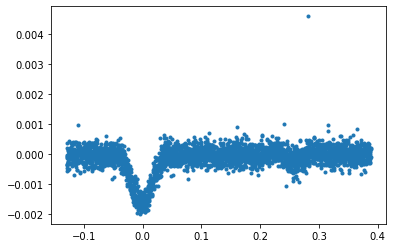

In [35]:
plt.plot(hdu[1].data['PHASE'],hdu[1].data['LC_DETREND'], marker='.',ls='None')
print(hdu[1].data['LC_INIT_ERR'])
master_u1=0.3975
master_u2=0.2650


### Limb Darkening Statistics
<table>
<tr>
    <td>KIC</td>
    <td>Rpl
    <td>Rorb
    <td>u1
    <td>u2
    <td>b
    <td>e
</tr>
<tr>
    <td>KIC 6620003</td>
    <td>0.16913
    <td>5.229
    <td>0.3803
    <td>0.3384
    <td>1.182
    <td>0
</tr>
<tr>
    <td>KIC 8323764</td>
    <td>0.16913
    <td>15.85
    <td>0.49
    <td>0.2075
    <td>0.557
    <td>0
</tr>
<tr>
    <td>KIC 11404644</td>
    <td>0.2159
    <td>9.7742
    <td>0.3147
    <td>0.3032
    <td>0.168
    <td>0
</tr>
<tr>
    <td>KIC 10295951</td>
    <td>0.114797
    <td>6.291
    <td>0.2412
    <td>0.3287
    <td>0.57
    <td>0
</tr>
<tr>
    <td>KIC 2557430</td>
    <td>0.43452 
    <td>1.93 
    <td>0.2893
    <td>0.3105
    <td>1.172 
    <td>0
</tr>
<tr>
    <td>KIC 8110757</td>
    <td>0.31774 (0.037)
    <td>1.528 (3.5193)
    <td>0.3975 
    <td>0.2650
    <td>1.262 (34.34 deg)
    <td>0
</tr>
<tr>
    <td>KIC 5357901</td>
    <td>0.108759
    <td>13.635
    <td>0.5256
    <td>0.1860
    <td>0.602 (88.65 deg)
    <td>0
</tr>
<tr>
    <td>KIC 5358624</td>
    <td>0.13372
    <td>11.699
    <td>0.5167
    <td>0.1914
    <td>0.12 (89.41 deg)
    <td>0
</tr>
<tr>
    <td>KIC 9651668</td>
    <td>0.121923
    <td>8.546
    <td>0.4415
    <td>0.2396
    <td>0.076 (89.49 deg)
    <td>0
</tr>
<tr>
    <td>KIC 5596440</td>
    <td>0.04377
    <td>1.346
    <td>0.2913
    <td>0.3120
    <td>0.972 (43.72 deg)
    <td>0
</tr>
<tr>
    <td>KIC 6372268</td>
    <td>0.04,0.03,0.002
    <td>24.4,17.7,51.52
    <td>1,-0.29,0.5 (-.1)
    <td>0,1,0
    <td>0
    <td>0
</tr>
</table>

### Fits and Parameters

In [37]:

popt1, pcov1 = curve_fit(new_plar_ma, np.array(df['phase']), np.array(df['flux']), 
    bounds=([0,master_u1-0.01,master_u2-0.01,1,0.9], [1,master_u1+0.01,master_u2+0.01,40,0.901]))

print("Var3d",np.trace(pcov1))
print("Params3d:",np.round(popt1,4))
print('rchi3d:',np.mean((df['flux']-new_plar_ma(np.array(df['phase']), *popt1))**2)/noise**2)

/home/ushasi/Documents/GitHub/alienworlds/Sims/transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


Var3d 36.84572116650089
Params3d: [0.0416 0.4075 0.275  1.4469 0.901 ]
rchi3d: 1.1858874119335285


In [8]:
popt3, pcov3 = curve_fit(new_plar_ellc_tide, np.array(df['phase']), np.array(df['flux']), 
    bounds=([0,master_u1-0.01,master_u2-0.01,1,0,1.5], [1,master_u1+0.01,master_u2+0.01,40,1.2,4.5]))

print("Var3d",np.trace(pcov3))
print("Params3d:",np.round(popt3,4))
print('rchi3d:',np.mean((df['flux']-new_plar_ellc_tide(np.array(df['phase']), *popt3))**2)/noise**2)

Var3d 59486612.35122929
Params3d: [0.2932 0.408  0.2765 2.5983 1.2    4.5   ]
rchi3d: 1.3113423825653112


In [38]:
popt2, pcov2 = curve_fit(new_plar_2d, np.array(df['phase']), np.array(df['flux']), 
    bounds=([0,master_u1-0.01,master_u2-0.01,1,0.9], [1,master_u1+0.01,master_u2+0.01,40,1.3]))

print("Var2d",np.trace(pcov2))
print("Params2d:",np.round(popt2,4))
print('rchi2d:',np.mean((df['flux']-new_plar_2d(np.array(df['phase']), *popt2))**2)/noise**2)

Var2d 0.006162451767844091
Params2d: [0.3066 0.3875 0.255  1.3885 1.1895]
rchi2d: 1.3052678342362818


In [39]:
from scipy.interpolate import interp1d
dfa=pd.read_csv('811_fit.csv')
check = np.array(dfa['model_fit'])

### Plotting the fits

2457
rchi3d_ma: 1.7341425505213428
rchi2d: 1.3631858379192539
rchi3d_c: 4.6531827785337105


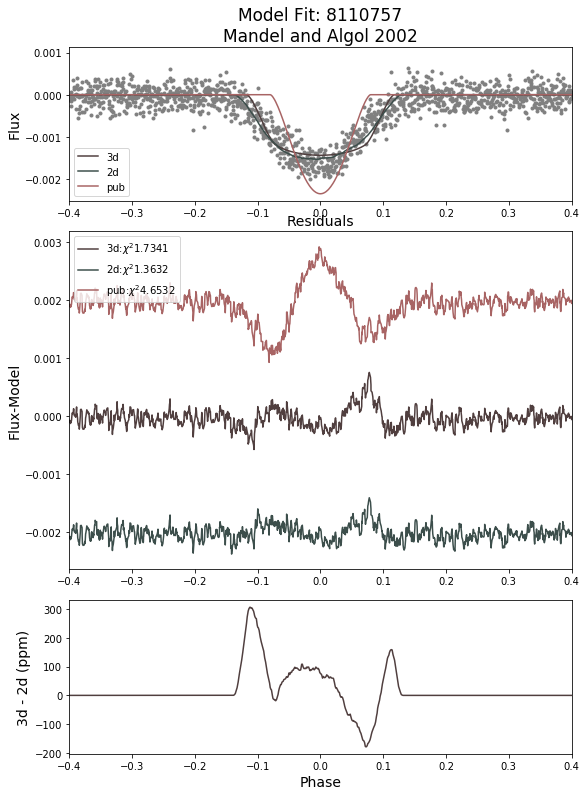

In [46]:
ca=["#e27c7c", "#a86464", "#6d4b4b", "#503f3f", "#333333", "#3c4e4b", "#466964", "#599e94", "#6cd4c5"]
fig = plt.figure(figsize=(9,13))
kernel =np.ones(5)/5

print(len(np.array(df['flux'])))
fl=np.array(df['flux'])
ph=np.array(df['phase'])
#noise=np.array(df['error'])
ax1 = plt.subplot2grid((4,1), (0, 0), rowspan=1)
ax2 = plt.subplot2grid((4,1), (1, 0), rowspan=2)
ax3 = plt.subplot2grid((4,1), (3, 0), rowspan=1)

exp1 = new_plar_ma(ph, *popt1)

rchi3d=np.sum((fl[900:1500]-exp1[900:1500])**2/noise**2)/(len(fl[900:1500])-3)
print('rchi3d_ma:',rchi3d)
ax1.plot(ph, exp1, label='3d', color=ca[3])
ax2.plot(ph,np.convolve(fl-exp1,  kernel, mode='same')+0.00, label='3d:$\chi^2$'+str(np.around(rchi3d,4)), color=ca[3])


exp2 = new_plar_2d(ph, *popt2)
exp2=check
rchi2d=np.sum((fl[900:1500]-exp2[900:1500])**2/noise**2)/(len(fl[900:1500])-3)
print('rchi2d:',rchi2d)
ax1.plot(ph,exp2, label='2d', color=ca[5])
ax2.plot(ph,np.convolve(fl-exp2,  kernel, mode='same')-0.002, label='2d:$\chi^2$'+str(np.around(rchi2d,4)), color=ca[5])

# exp3 = new_plar_ellc_tide(ph, *popt3)
# rchi3d_el=np.sum((fl[900:1500]-exp3[900:1500])**2/noise[900:1500]**2)/(len(fl[900:1500])-3)
# print('rchi3d_el:',rchi3d_el)
# ax1.plot(ph, exp3, label='3d(tide)', color=ca[7])
# ax2.plot(df['phase'],np.convolve(fl-exp3,  kernel, mode='same')-0.002, label='3d(tide):$\chi^2$'+str(np.around(rchi3d_el,4)), color=ca[7])

expc = new_plar_ma(ph, 0.3177, master_u1, master_u2, 1.528, 1.262)
rchipub=np.sum((fl[900:1500]-expc[900:1500])**2/noise**2)/(len(fl[900:1500])-3)
print('rchi3d_c:',rchipub)
ax1.plot(ph, expc,  label='pub', color=ca[1])
ax2.plot(ph,np.convolve(fl-expc,  kernel, mode='same')+0.002, label='pub:$\chi^2$'+str(np.around(rchipub,4)),color=ca[1])

ax1.set_title('Model Fit: 8110757\nMandel and Algol 2002', size=17)
ax1.plot(ph,fl, color='gray', zorder=1, marker='.', ls='None')

ax2.set_title('Residuals', size=14)
ax3.set_xlabel('Phase', size=14)
ax1.set_ylabel('Flux', size=14)
ax1.legend()
ax2.set_ylabel('Flux-Model', size=14)
ax1.set_xlim(-0.4,0.4)
ax2.set_xlim(-0.4,0.4)
ax3.set_xlim(-0.4,0.4)

ax3.plot(ph,(exp1-exp2)*10**6, color=ca[3])
ax3.set_ylabel('3d - 2d (ppm)',size=14)

ax2.legend(loc='upper left')

#print('old',np.std(exp- df['flux']), 'new:',np.std(exp2- df['flux']))
plt.savefig("fprez_8110757.png")


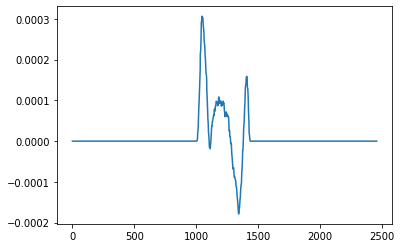

In [15]:
plt.plot(exp1-exp2)

### Trying out a 2D simulation...

In [ ]:
nflux=[x for x,y in zip(df['flux'],df['phase']) if(y<0.05 and y>-0.05)]
print(len(nflux))

In [ ]:
#trying out a simulation
sim = dy.Simulator(1, 10000, 800, 0.1*np.pi, 0.4167, 0.1914)
meg = dy.Megastructure(11.699, True, 0.13, ecc=0, per_off=0, isrot=False, elevation=0.012)
sim.add_megs(meg)

sim2 = dy.Simulator(1, 10000, 800, 0.1*np.pi, 0.4167, 0.1914)
meg2 = dy.Megastructure(11.699, True, 0.13, ecc=0, per_off=0, isrot=True, elevation=0.012)
sim2.add_megs(meg2)

# sim3 = dy.Simulator(1, 20000, 400, 0.1*np.pi, 0.3975, 0.2650)
# meg3 = dy.Megastructure(6.98, True, 0.015, ecc=0, per_off=0, isrot=False)
# sim3.add_megs(meg3)




In [ ]:
netlc=[]
netph=[]
for i in range(2):
    np.random.seed(1234*i)
    road, ph, lc = sim.simulate_transit()
    netlc.append(lc)
    print('3d:',i)
    sim.initialize()

# netlc3=[]
# for i in range(50):
#     np.random.seed(1234*i)
#     road3, ph3, lc3 = sim3.simulate_transit()
#     netlc3.append(lc3)
#     print('3d2:',i)
#     sim3.initialize()

netlc2=[]
for i in range(2):
    np.random.seed(3456*i)
    road2, ph2, lc2 = sim2.simulate_transit()
    netlc2.append(lc2)
    print('2d:',i)
    if(i==9): netph.append(ph2)
    sim2.initialize()

lc = np.mean(np.array(netlc), axis=0)
# lc3 = np.mean(np.array(netlc3), axis=0)
lc2 = np.mean(np.array(netlc2), axis=0)


In [ ]:
from multiprocessing import Process, Pool

def test_multi_loops_3d(x):
    np.random.seed(1234*x)
    sim = dy.Simulator(1, 2000, 200, 0.1*np.pi, 2*0.3975, 0.2650)
    meg = dy.Megastructure(13.45, True, 0.035, ecc=0.377, per_off=np.pi/2)
    sim.add_megs(meg)
    sim.simulate_transit()
    if(x==0): print("Count:", meg.set)
    return(sim.frames,sim.lc)

def test_multi_loops_2d(x):
    np.random.seed(3456*x)
    sim2 = dy.Simulator(1, 2000, 200, 0.1*np.pi, 2*0.3975, 0.2650)
    meg2 = dy.Megastructure(13.45, True, 0.035, ecc=0.377, per_off=np.pi/2, isrot=True)
    sim2.add_megs(meg2)
    if(x==0): print("Count:", meg.set)
    sim.simulate_transit()
    return(sim.frames,sim.lc)



if __name__ == '__main__':
    # start 4 worker processes
    with Pool(processes=4) as pool:
        frm,lc2dsum = np.asarray(pool.map(test_multi_loops_2d, range(8)))
        lc2d = np.mean(lc2dsum, axis = 0)
        #print("--- %s min ---" % ((time.time() - start_time)/60))

        frm,lc3dsum = np.asarray(pool.map(test_multi_loops_3d, range(8)))
        #print("--- %s min ---" % ((time.time() - start_time)/60))

        lc3d = np.mean(lc3dsum, axis = 0)

        mn = (np.asarray(lc3d-lc2d)**2).sum()/len(lc3d)
        print(np.sqrt(mn))


In [ ]:
plt.style.use('seaborn-bright')
plt.figure(figsize=(10,5))
#print(lc.shape, ph.shape)
kernel = np.ones(30)/30
plt.plot(np.array(ph)*0.5/np.pi,np.array(lc)-1, color='blue', label='3d')
plt.plot(np.array(ph)*0.5/np.pi,np.array(lc2)-1, color='red', label='3d')
plt.plot(np.array(ph)*0.5/np.pi,nflux, color='gray', label='data')
#plt.plot(np.array(df['phase']),np.convolve(np.array(df['flux']), kernel,mode='same'),color='gray')
#plt.plot(np.array(df['phase']), exp2, color='black', label='fit LD old')
#plt.plot(np.array(ph)/np.pi,np.array(lc2)-1, color='blue', label='2d')
# plt.plot(np.array(ph)/np.pi+0.5,np.array(lc3)-1, color='blue', label='3d')
plt.title('Global View')
plt.xlabel('Phase')
plt.ylabel('Flux')
#plt.xlim(-0.1,+0.1)
#plt.ylim(-0.2,.2)
#plt.savefig('not_a_fit.png')

In [ ]:
plt.plot(ph*0.5/np.pi,nflux-lc+1)
plt.plot(ph*0.5/np.pi,nflux-lc2+1)
print(np.std(nflux-lc+1), np.std(nflux-lc2+1))

### Cadence Problem

In [ ]:
alt = 30
ph = np.linspace(-0.125,0.125,300)
fl = new_plar(ph, 0.12,0.0,0.0,3,0.0)
fl_smooth = np.convolve(fl,np.ones(alt)/alt,mode='same')
# ph_smooth = [ph[i] for i in range(50,len(ph),100)]
# fl_smooth = [np.mean(fl[i:i+100]) for i in range(0,len(fl),100)]
fig, ax = plt.subplots(1,1,figsize=(7,5))
ax.set_title('Cadence Problem \n $R_{pl}=0.1 R_{st}$,$R_{orb}=3 R_{st}$')
ax.plot(ph,fl, label='sim', color='green')
#ax.plot(ph_smooth, fl_smooth, label='avg')
ax.plot(ph, fl_smooth, label='avg', color='red')
ax.legend()
#plt.savefig('fprez_cadence.jpg')
#plt.plot(ph, fl-fl_smooth)
print(-np.max(fl-fl_smooth)/np.min(fl))

In [ ]:
alt = 100
devarr=[]
timearr=np.linspace(10,90,9)
mptarr=[]

ca2=["#e27c7c", "#a86464", "#6d4b4b", "#503f3f", "#333333", "#3c4e4b", "#466964", "#599e94", "#6cd4c5"]

fig, ax = plt.subplots(1,1,figsize=(7,5))
i=0
for t in timearr:
    temp=[]
    ptarr=np.floor(np.linspace(t,10000,40))
    mptarr.append(ptarr)
    for pt in ptarr:
        ph = np.linspace(-0.125,0.125,int(pt))
        fl = new_plar(ph, 0.1,0.0,0.0,3,0.0)
        fl_smooth = np.convolve(fl,np.ones(int(t))/int(t),mode='same')
        val=-np.max(fl-fl_smooth)/np.min(fl)
        temp.append(val)
    devarr.append(temp)
    ax.plot(ptarr,temp, label=str(int(t)), color=ca2[i])
    i+=1


ax.set_xscale('log')
ax.set_title('Cadence Problem \n $R_{pl}=0.1 R_{st}$,$R_{orb}=3 R_{st}$')
ax.set_ylabel('percent deviation')
ax.set_xlabel('Points')
ax.legend()

plt.savefig('fprez_cad_demo2.jpg')

